# Introducción a los bosques de corte aleatorio de SageMaker

[LINK](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/random_cut_forest/random_cut_forest.ipynb)

In [15]:
import boto3
import botocore
import sagemaker
import sys

In [20]:
bucket = (
    sagemaker.Session().default_bucket()
)  # Feel free to change to another bucket you have access to
prefix = "sagemaker/rcf-benchmarks"
execution_role = 'AmazonSageMaker-ExecutionRole-20220328T145246'
region = boto3.Session().region_name
print(f"Bucket: {bucket}")

Bucket: sagemaker-us-east-1-195566616656


In [21]:
# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-sample-files"
downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"

In [22]:
def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission

In [23]:
if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}"
    )

Training input/output will be stored in: s3://sagemaker-us-east-1-195566616656/sagemaker/rcf-benchmarks
Downloaded training data will be read from s3://sagemaker-sample-files/datasets/tabular/anomaly_benchmark_taxi


In [24]:
%%time

import pandas as pd

data_filename = "NAB_nyc_taxi.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=",")

CPU times: user 130 ms, sys: 4.63 ms, total: 134 ms
Wall time: 321 ms


In [26]:
taxi_data.head()

timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820

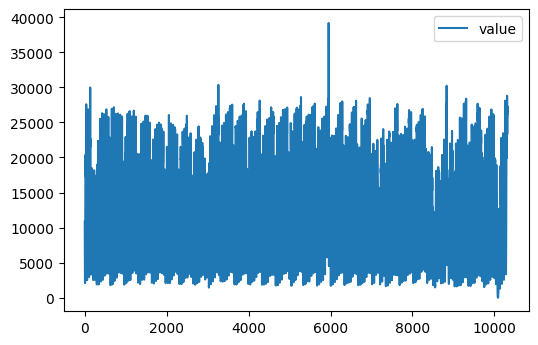

In [28]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 100

taxi_data.plot();

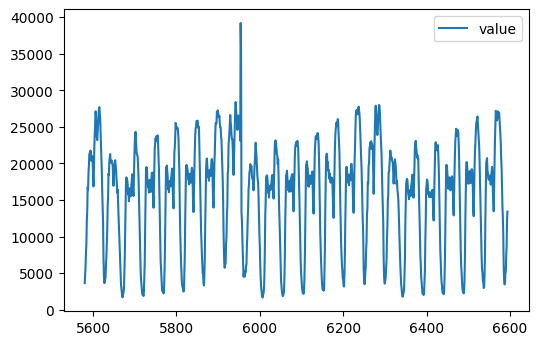

In [33]:
taxi_data[5580:6595].plot();

In [37]:
taxi_data[5952:5965]

timestamp  value
5952  2014-11-02 00:00:00  25110
5953  2014-11-02 00:30:00  23109
5954  2014-11-02 01:00:00  39197
5955  2014-11-02 01:30:00  35212
5956  2014-11-02 02:00:00  13259
5957  2014-11-02 02:30:00  12250
5958  2014-11-02 03:00:00  10013
5959  2014-11-02 03:30:00   7898
5960  2014-11-02 04:00:00   6375
5961  2014-11-02 04:30:00   4532
5962  2014-11-02 05:00:00   5116
5963  2014-11-02 05:30:00   5232
5964  2014-11-02 06:00:00   4542

In [38]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data.value.to_numpy().reshape(-1, 1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-04-27 00:58:05 Starting - Starting the training job...
2022-04-27 00:58:32 Starting - Preparing the instances for trainingProfilerReport-1651021085: InProgress
.........
2022-04-27 01:00:02 Downloading - Downloading input data......
2022-04-27 01:00:59 Training - Downloading the training image...
2022-04-27 01:01:39 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/27/2022 01:01:45 INFO 139815788971840 integration.py:636] worker started
[04/27/2022 01:01:45 INFO 139815788971840] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_object

In [39]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2022-04-27-00-58-05-414


In [40]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


------!

In [41]:
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2022-04-27-01-03-00-916


In [42]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

In [43]:
taxi_data_numpy = taxi_data.value.to_numpy().reshape(-1, 1)
print(taxi_data_numpy[:6])
results = rcf_inference.predict(
    taxi_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

[[10844]
 [ 8127]
 [ 6210]
 [ 4656]
 [ 3820]
 [ 2873]]


In [44]:
results = rcf_inference.predict(taxi_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to taxi data frame and print first few values
taxi_data["score"] = pd.Series(scores, index=taxi_data.index)
taxi_data.head()

timestamp  value     score
0  2014-07-01 00:00:00  10844  1.039514
1  2014-07-01 00:30:00   8127  1.029384
2  2014-07-01 01:00:00   6210  0.988584
3  2014-07-01 01:30:00   4656  0.911292
4  2014-07-01 02:00:00   3820  0.879395

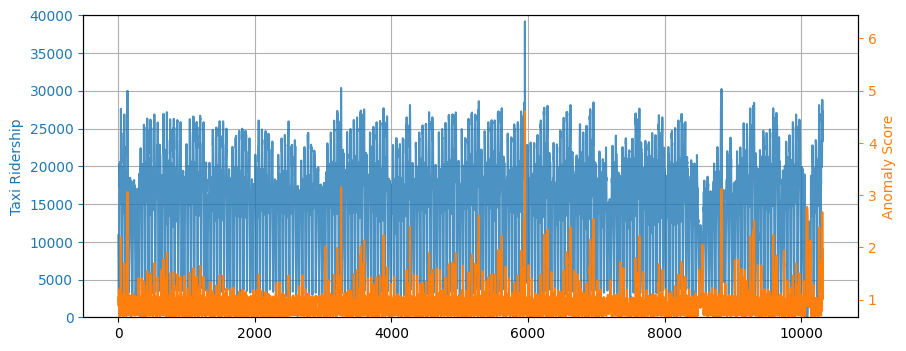

In [45]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
# start, end = 5500, 6500
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data_subset["value"], color="C0", alpha=0.8)
ax2.plot(taxi_data_subset["score"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

In [46]:
score_mean = taxi_data["score"].mean()
score_std = taxi_data["score"].std()
score_cutoff = score_mean + 3 * score_std

anomalies = taxi_data_subset[taxi_data_subset["score"] > score_cutoff]
anomalies

timestamp  value     score
37     2014-07-01 18:30:00  27598  2.189453
38     2014-07-01 19:00:00  26827  1.684940
87     2014-07-02 19:30:00  26872  1.699862
134    2014-07-03 19:00:00  29985  3.057521
527    2014-07-11 23:30:00  26873  1.699686
...                    ...    ...       ...
10270  2015-01-30 23:00:00  26928  1.730542
10309  2015-01-31 18:30:00  27286  1.952488
10310  2015-01-31 19:00:00  28804  2.671885
10311  2015-01-31 19:30:00  27773  2.245345
10317  2015-01-31 22:30:00  27309  1.965798

[195 rows x 3 columns]

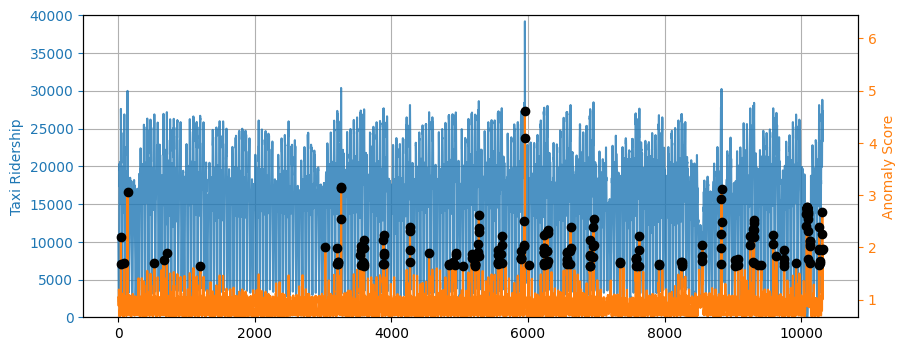

In [47]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

In [48]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [52]:
import numpy as np


def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data - shingle_size, shingle_size))

    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n : (n + shingle_size)]
    return shingled_data


# single data with shingle size=48 (one day)
shingle_size = 48
prefix_shingled = "sagemaker/randomcutforest_shingled"
taxi_data_shingled = shingle(taxi_data.values[:, 1], shingle_size)
print(taxi_data_shingled)

[[10844.  8127.  6210. ... 21733. 20104. 16111.]
 [ 8127.  6210.  4656. ... 20104. 16111. 13370.]
 [ 6210.  4656.  3820. ... 16111. 13370.  9945.]
 ...
 [26874. 26928. 26000. ... 23719. 24670. 25721.]
 [26928. 26000. 25778. ... 24670. 25721. 27309.]
 [26000. 25778. 23304. ... 25721. 27309. 26591.]]


In [53]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix_shingled}/",
    output_path=f"s3://{bucket}/{prefix_shingled}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data_shingled))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-04-27 01:13:41 Starting - Starting the training job...
2022-04-27 01:14:04 Starting - Preparing the instances for trainingProfilerReport-1651022020: InProgress
.........
2022-04-27 01:15:37 Downloading - Downloading input data...
2022-04-27 01:16:08 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/27/2022 01:16:55 INFO 140255510312768 integration.py:636] worker started
[04/27/2022 01:16:55 INFO 140255510312768] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[04/27/2022 01:16:55 INFO 140255510312768] Merging wit

In [54]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------!

In [55]:
print(rcf_inference.content_type, rcf_inference.accept)

text/csv ('application/json',)


In [56]:
# Score the shingled datapoints
results = rcf_inference.predict(
    taxi_data_shingled, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)
scores = np.array([datum["score"] for datum in results["scores"]])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 3 * score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

[1.453398   1.43689669 1.44808651 1.49337067 1.51074849 1.53591785
 1.58859876 1.57360929 1.62437046 1.68915794 1.64985237 1.61975329
 1.70823125 1.70126821 1.73821864 1.76174797 1.73657851 1.73192876
 1.74842612 1.63505033 1.53936191 1.50569449 1.69157432 1.72746996
 1.64493031 1.60533811 1.57898719 1.60172368 1.5728291  1.55395486
 1.58140601 1.54972197 1.46222543 1.55674557 1.55629524 1.46952436
 1.44437019 1.44975338 1.46131533 1.4692033  1.45137299 1.48299176
 1.50053282 1.47401968 1.50654217 1.54538164 1.58932289 1.50152779
 1.46681776 1.4965702  1.51784744 1.565696   1.56534343 1.57302139
 1.56759735 1.58305438 1.54537367 1.59187514 1.54608717 1.58974607
 1.55893039 1.50560981 1.4785793  1.48365269 1.48501053 1.47741296
 1.45347863 1.45884155 1.4905194  1.48056505 1.46951778 1.46850259
 1.4629729  1.50342666 1.48623193 1.56734494 1.43638209 1.46766317
 1.4614818  1.47031478 1.53737779 1.57684287 1.58405364 1.59879515
 1.64248809 1.67375108 1.63579957 1.74549698 1.76994457 1.7856

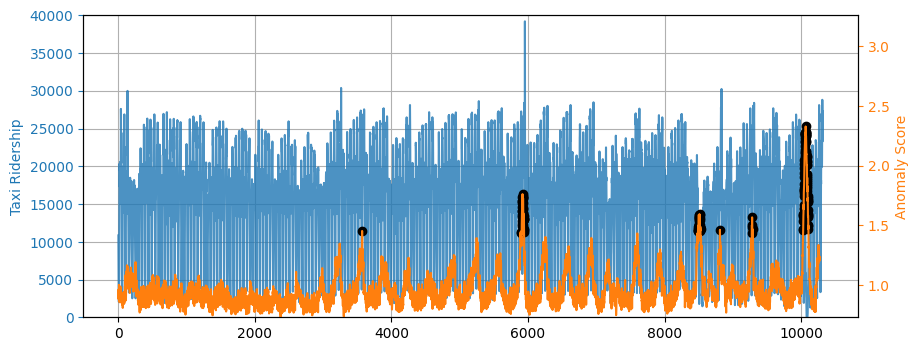

In [57]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data["value"], color="C0", alpha=0.8)
ax2.plot(scores, color="C1")
ax2.scatter(anomaly_indices, anomalies, color="k")

ax1.grid(which="major", axis="both")
ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

In [58]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
